# emcee hubble
## Implementación en Python 
### José Alberto Moreno Guerra

In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt

# Choose the "true" parameters.
H_true = 83.94
om_true = 0.294
f_true = 0.534

In [2]:
# Abrimos el arch. que contiene los datos 
f1=np.loadtxt('jla_mub_covmatrix.txt',delimiter = '\t',skiprows=0,usecols=[0,0]) 
f2=np.loadtxt('jla_mub.txt',delimiter = '\t',skiprows=0,usecols=[0,1]) 
covmatrix=f1[:,0]
z=f2[:,0]
mud=f2[:,1]
n=np.size(covmatrix) # Contabilizamos el número de datos que tenemos

In [3]:
cov=np.ones((31, 31))
m=0
for i in range(31):
    for j in range(31):
        cov[i][j]=covmatrix[m]
        m=m+1
var=np.diag(cov)

In [4]:
def eta(a,om):
    s3=(1.-om)/om
    s2=s3**(2./3)
    s=s3**(1./3)
    coef=[0.1540,0.4304,0.19097,0.066941]
    return 2.*np.sqrt(s3+1.)*((1./a**4)-coef[0]*s*(1./a**3)+coef[1]*s2*(1./a**2)+coef[2]*s3*(1./a)+coef[3]*(s**4))**(-1./8)
# Definición del likelihood

### Maximum Likelihood estimation 

$-Ln(\mathfrak{L}(\vec{x},\vec{y}\mid \vec{\theta }))\propto \frac{1}{2}\sum_{i}^{n}\left ( \frac{y_{i}-\lambda (x_{i},\vec{\theta })}{\sigma_{i}} \right )^{2}$

In [5]:
pi=np.arccos(-1) # Pi
def lnlike(theta, z, y, var):
    H, om, lnf = theta
    c=299792.0 # velocidad de la luz en km/s
    a=1./(1+z)
    D =(c/H)*(1./a)*(eta(1.,om)-eta(a,om))
    model = 25.-5.*np.log10(H/100.0)+5.*np.log10(D)
    inv_sigma2 = 1.0/(var + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [6]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
bnds= ((74.0,84.0),(0.1,.3),(0.0,3.0))
result= op.minimize(nll,[75, .05, 0.534], args=(z, mud, var), bounds=bnds)
H_ml, om_ml, lnf_ml = result["x"]

In [7]:
print(H_ml, om_ml, lnf_ml)

(84.0, 0.29999999999999999, 0.0)


In [8]:
def sup(H,om,z):
    c=299792.0 # velocidad de la luz en km/s
    a=1./(1+z)
    D =(c/H)*(1./a)*(eta(1.,om)-eta(a,om))
    y = 25.-5.*np.log10(H/100.0)+5.*np.log10(D)
    return y

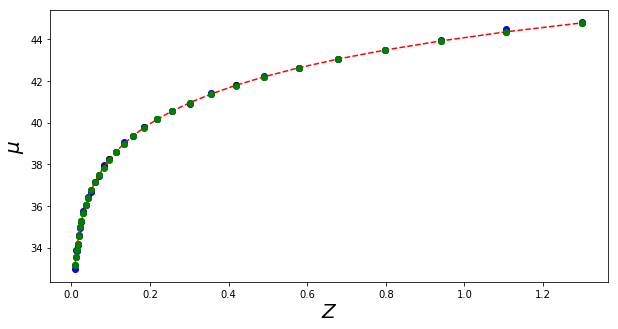

In [9]:
plt.figure(figsize=(10,5))
plt.plot(z,mud,'bo')
y1 = sup(H_true,om_true,z)
plt.plot(z,y1,'ko')
y2= sup(H_ml,om_ml,z)
plt.plot(z,y1,'r--')
plt.plot(z,y2,'go')
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
plt.show()

### Marginalization & uncertainty estimation 

$p(m,b,f\mid x,y,\sigma )\propto p(m,b,f)p(y\mid x,\sigma ,m,b,f)$

In [10]:
def lnprior(theta):
    H, om, lnf = theta
    if 75 < H < 85 and 0.0 < om < 1.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [11]:
def lnprob(theta, z, y, var):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, z, y, var)

In [12]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [13]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(z, mud, var))

In [14]:
sampler.run_mcmc(pos, 500)
print()

()


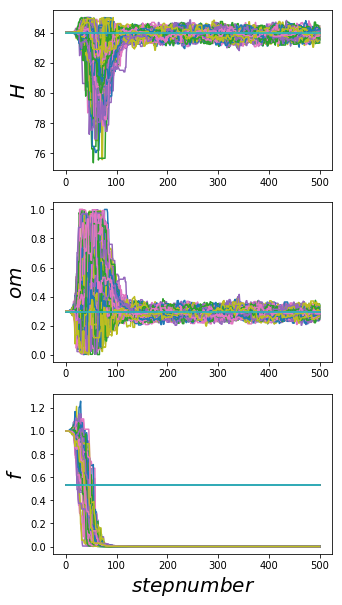

In [15]:
x1 = np.linspace(0.0, 500, 500)
plt.figure(figsize=(5,10))
for i in range(100):
    plt.subplot(3, 1, 1)
    plt.plot(x1, sampler.chain[i,:,0], '-')
    plt.plot(x1, H_true*np.ones(500), '-')
    plt.ylabel('$H$',fontsize = 20)

    plt.subplot(3, 1, 2)
    plt.plot(x1, sampler.chain[i,:,1], '-')
    plt.plot(x1, om_true*np.ones(500), '-')
    plt.ylabel('$om$',fontsize = 20)

    plt.subplot(3, 1, 3)
    plt.plot(x1, np.exp(sampler.chain[i,:,2]), '-')
    plt.plot(x1, f_true*np.ones(500), '-')
    plt.xlabel('$stepnumber$',fontsize = 20)
    plt.ylabel('$f$',fontsize = 20)
plt.show()

In [16]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

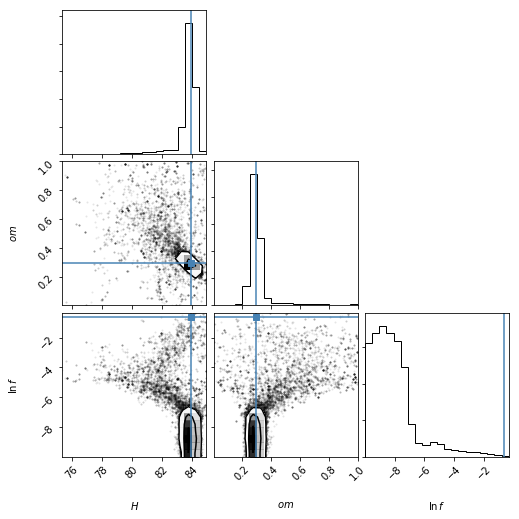

In [17]:
import corner
fig = corner.corner(samples, labels=["$H$", "$om$", "$\ln\,f$"],
                      truths=[H_true, om_true, np.log(f_true)])
fig.savefig("hubble.png")

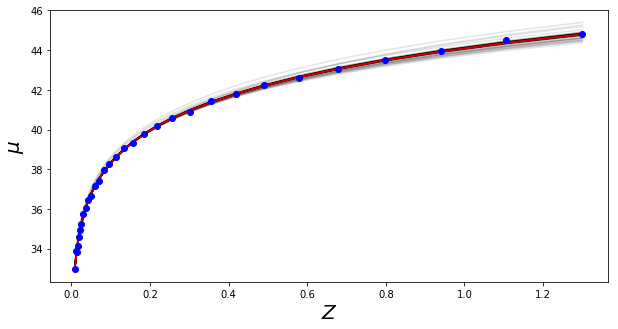

In [18]:
plt.figure(figsize=(10,5))
xl = np.array([0, 10])
for H, om, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(z, sup(H,om,z), color="k", alpha=0.1)
plt.plot(z, sup(H_true,om_true,z), color="r", lw=2, alpha=0.8)
plt.plot(z,mud,'bo')
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
plt.show()